# Model: Decision Tree

## Date: Nov 23, 2023

---

## Introduction

For the next model, a decision tree will be used. This gives a good variety as log reg is probability based, svm distance based. It also handles non linearity well compared to linear SVM, log reg, and is a much quicker algorithm for large datasets compared to svm's. Since the last few model accuracies stagnated, there might be some non linearity in the data they are not capturing well. Therefore a decision tree is a good next model, however they can be prone to overfitting.  

Unlike with the previous models, the data does not need to be scaled. As it is nonlinear, the linear assumptions dont need to be satisfied. This results in not having to check and remove features with high colinearity and multicollinearity, and therefore more features will be included in this model compared to the previous models. However, this is an advantage of decision trees, so as long this caveat is kept in mind, the comparison can still be made. 

The hyperparameters that can be used:  
1. max_depth: The maximum depth of the tree. This controls overfitting as higher depth allows the model to discern more and more
2. min_samples_split: The minimum number of samples required to split an internal node. Higher values prevent the model from learning too much detail.
3. 
min_samples_leaf: The minimum number of samples required to be at a leaf node. Similar to min_samples_split, it controls overfittin 
4. 
max_features: The number of features to consider when looking for the best sp- 
5. .
max_leaf_nodes: Limits the number of leaf nodes in the tree, helping to control overfiig.  
6. g.
criterion: The function used to measure the quality of a split. Common criteria include 'gini' for Gini Impurity and 'entropy' for Information G
7. min_impurity_decrease: The minimum decrease in inpurity for the next split to be performed.  
  
 Note: There was a visualization error with the confusion matrices. The matrix is also printedain.

--------

### Table of Contents

1. [Introduction](#Introduction)
   - [Table of Contents](#Table-of-contents)
   - [Import Librarys](#Import-Librarys)
   - [Data Dictionary](#Data-Dictionary)
   - [Define Functions](#Define-Functions)
   - [Load the data](#Load-the-data)
3. [Decision Tree](#Decision-Tree)
   - [1st Iteration](#1st-Iteration)
   - [2nd Iteration](#2nd-Iteration)
   - [3rd (Final) Iteration](#3rd-(Final)-Iteration)
4. [Random Forest](#Random-Forest)
5. [Conclusion](#Conclusion)


### Import Librarys

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

import shap

from pathlib import Path
from joblib import dump
from helpers import display_corr_heatmap, data_dict

### Data Dictionary

In [2]:
data_dict()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


### Load the Data

In [3]:
# Define the relative path to the file
parquet_file_path = Path('../Data/Lending_club/model_cleaned')

try:
    # Read the parquet file
    loans_df = pd.read_parquet(parquet_file_path)
except FileNotFoundError as e:
    print(e.args[1])
    print('Check file location')

In [4]:
loans_df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
50867,23000.0,36,12.05,764.479980,3.0,RENT,50000.0,Source Verified,1,debt_consolidation,13.900000,0.0,1.0,8.0,0.0,9976.0,45.599998,12.0,0.0,Individual,0.0,0.0,11973.0,21900.0,2.0,1710.0,11924.0,45.599998,0.0,0.0,110.0,119.0,5.0,5.0,0.0,5.0,2.0,4.0,4.0,4.0,6.0,5.0,5.0,7.0,4.0,8.0,0.0,1.0,81.800003,0.000000,0.0,0.0,28207.0,11973.0,21900.0,6307.0
373353,35000.0,60,17.57,880.609985,2.0,RENT,110000.0,Verified,1,debt_consolidation,31.629999,0.0,0.0,27.0,0.0,50450.0,75.599998,38.0,0.0,Individual,0.0,541.0,304808.0,66700.0,3.0,11289.0,9169.0,81.599998,0.0,0.0,138.0,193.0,11.0,3.0,1.0,47.0,0.0,7.0,10.0,8.0,13.0,17.0,14.0,19.0,10.0,27.0,0.0,3.0,91.900002,50.000000,0.0,0.0,336948.0,215616.0,49900.0,134250.0
185185,33100.0,36,13.99,1131.119995,1.0,MORTGAGE,72000.0,Source Verified,1,debt_consolidation,12.130000,0.0,2.0,10.0,0.0,16993.0,37.599998,29.0,0.0,Individual,0.0,89.0,33172.0,45200.0,3.0,3686.0,8802.0,64.800003,0.0,0.0,143.0,247.0,10.0,10.0,0.0,43.0,0.0,3.0,4.0,3.0,9.0,7.0,9.0,22.0,4.0,10.0,0.0,1.0,100.000000,33.299999,0.0,0.0,67371.0,33172.0,25000.0,22171.0
33164,1000.0,36,11.22,32.849998,10.0,RENT,40000.0,Verified,1,vacation,18.270000,0.0,1.0,9.0,0.0,12175.0,39.799999,13.0,0.0,Individual,0.0,0.0,25333.0,30600.0,5.0,2815.0,17325.0,41.299999,0.0,0.0,19.0,132.0,1.0,1.0,0.0,1.0,0.0,4.0,4.0,6.0,8.0,2.0,7.0,11.0,4.0,9.0,0.0,3.0,100.000000,16.700001,0.0,0.0,46125.0,25333.0,29500.0,15525.0
368586,4400.0,36,12.29,146.759995,3.0,RENT,34000.0,Verified,1,debt_consolidation,8.860000,0.0,0.0,6.0,0.0,10915.0,78.000000,17.0,0.0,Individual,0.0,0.0,10915.0,14000.0,0.0,2183.0,1985.0,84.599998,0.0,0.0,123.0,172.0,29.0,29.0,0.0,33.0,0.0,4.0,4.0,4.0,9.0,3.0,6.0,14.0,4.0,6.0,0.0,0.0,100.000000,100.000000,0.0,0.0,14000.0,10915.0,12900.0,0.0


### Decision Tree model

### Preprocessing

***Train test split***

In [5]:
# Split the data
X = loans_df.drop(columns=['loan_status'], inplace=False)
y = loans_df['loan_status']

# Split into train and test sets. Stratify to ensure any inbalance is preserved as in the original data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

***Data Inbalance***

Decision trees are still sensitive to data inbalance, so the data will be balanced again.

In [6]:
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

# Downsample majority class
X_downsampled, y_downsampled  = resample(X_train[y_train == 1],
                                   y_train[y_train == 1],
                                   replace=False,
                                   n_samples=X_train[y_train == 0].shape[0],
                                   random_state=1)

print('\nNumber of class 1 examples after:', X_downsampled.shape[0])

# Combine the downsampled successful loans with the failed loans. Will keep as a df since changing to 
X_train_bal = pd.concat([X_train[y_train == 0], X_downsampled])
y_train_bal = np.hstack((y_train[y_train == 0], y_downsampled))

print("New X_train shape: ", X_train_bal.shape)
print("New y_train shape: ", y_train_bal.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Number of class 1 examples before: 247290

Number of class 1 examples after: 65003
New X_train shape:  (130006, 55)
New y_train shape:  (130006,)
X_test shape:  (133841, 55)
y_test shape:  (133841,)


No features need to be dropped so there are now 25 extra features that were not available in log reg and svm

***Inspect Categorical Features***

Categorical features have to be numerically encoded. The encodings will be the same as the other notebooks.

In [7]:
categorical_columns = X_train_bal.select_dtypes('object').columns.tolist()
display(categorical_columns)
categorical_columns.remove('verification_status')

['home_ownership', 'verification_status', 'purpose', 'application_type']

In [8]:
# Instantiate
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[['Not Verified', 'Source Verified', 'Verified']])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['home_ownership', 'verification_status', 'purpose', 'application_type']),
        ('ord', ordinal_transformer, ['verification_status'])],
    remainder='passthrough',
    n_jobs=2
)

# Fit to the train set
preprocessor.fit(X_train_bal)

# Transform the train and test sets
X_train_transformed = preprocessor.transform(X_train_bal)
X_test_transformed = preprocessor.transform(X_test)

print("Shape of train transformed: ", X_train_transformed.shape)
print("Shape of test transformed: ", X_test_transformed.shape)

Shape of train transformed:  (130006, 75)
Shape of test transformed:  (133841, 75)


## Decision Tree

### 1st Iteration

Since there are so many hyperparameters for decision trees, it does not make sense to manually iterate one by one to find acceptable hyperparameter ranges for the final iteration, like what was done for log reg and svm. Instead, a randomized gridsearch, which simply computes random combinations of hyperparameters, is more efficent. This works like the GridsearchCV function seen in the other notebooks, however it simply takes a random sample of hyperparamter combinations, as opposed to an exhaustive search. This saves on computations and time.

***Run the first iteration***

In [9]:
%%time
# Instantiate decision tree
dt_classifier = DecisionTreeClassifier(random_state=1)

# Hyperparameters grid to search
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 7, 8, 9],
    "min_samples_split": [4,5,6],
    "min_samples_leaf": [9, 10, 11],
    "max_features": [None, "sqrt", "log2"]
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='binary', pos_label=1) #f1 score for class 1
}

# Randomized Grid Search with cross-validation
random_search = RandomizedSearchCV(
    dt_classifier, 
    param_distributions=param_dist, 
    n_iter=100, #pull out 100 combinations
    scoring=scoring, 
    refit='f1', #refit on f1 for class 1
    cv=5, #5 fold cross validation
    random_state=1, 
    verbose=10,
    n_jobs=3 #adjust based on your cpu cores
)

# Fit
random_search.fit(X_train_transformed, y_train_bal)

# Best model
best_dt_model = random_search.best_estimator_

# Best hyperparameters
best_params = random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 9.44 s
Wall time: 8min 24s


In [10]:
# Best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 8, 'criterion': 'entropy'}


***Score the first iteration***

In [11]:
# Make predictions on both training and test data
y_pred_train = best_dt_model.predict(X_train_transformed)
y_pred_test = best_dt_model.predict(X_test_transformed)

# Calculate accuracies for train and test sets
train_accuracy = accuracy_score(y_train_bal, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print the train and test accuracies
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Check for any overfitting
if train_accuracy > test_accuracy:
    print("The model might be overfitting.")
else:
    print("The model seems to generalize well.")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Confusion maxtrix")
print(conf_matrix)

Train Accuracy: 0.654454409796471
Test Accuracy: 0.6209308059563213
The model might be overfitting.
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.67      0.42     27859
           1       0.87      0.61      0.72    105982

    accuracy                           0.62    133841
   macro avg       0.59      0.64      0.57    133841
weighted avg       0.76      0.62      0.66    133841

Confusion maxtrix
[[18639  9220]
 [41515 64467]]


***1st model Interpretation***

For the first iteration, there is noticeable overfitting. The model underperformed relative to the baseline log reg model, even though it was observed that there were many non linear relationships. The weighted average F1 score, a good overall metric, is lower than log reg's 0.69.
Overall, the model overfit, and underperformed. A tree depth of 8 is quite high and will be adjusted next to control the overfitting. Further interpretation will be done once the model generalizes well. 

***1st model Feature importance***

For log reg, the coefficients gave information on how much predictability a feature had. With a decision tree, feature importance is calculated based on the features ability to reduced impurity, ie segment the data into "pure" buckets. Impurity is a measure of the homogeneity of the labels at a node. Features that are able to greatly reduce impurity, ie are great discerners for the different classes, are given a high importance. 

<class 'numpy.ndarray'>


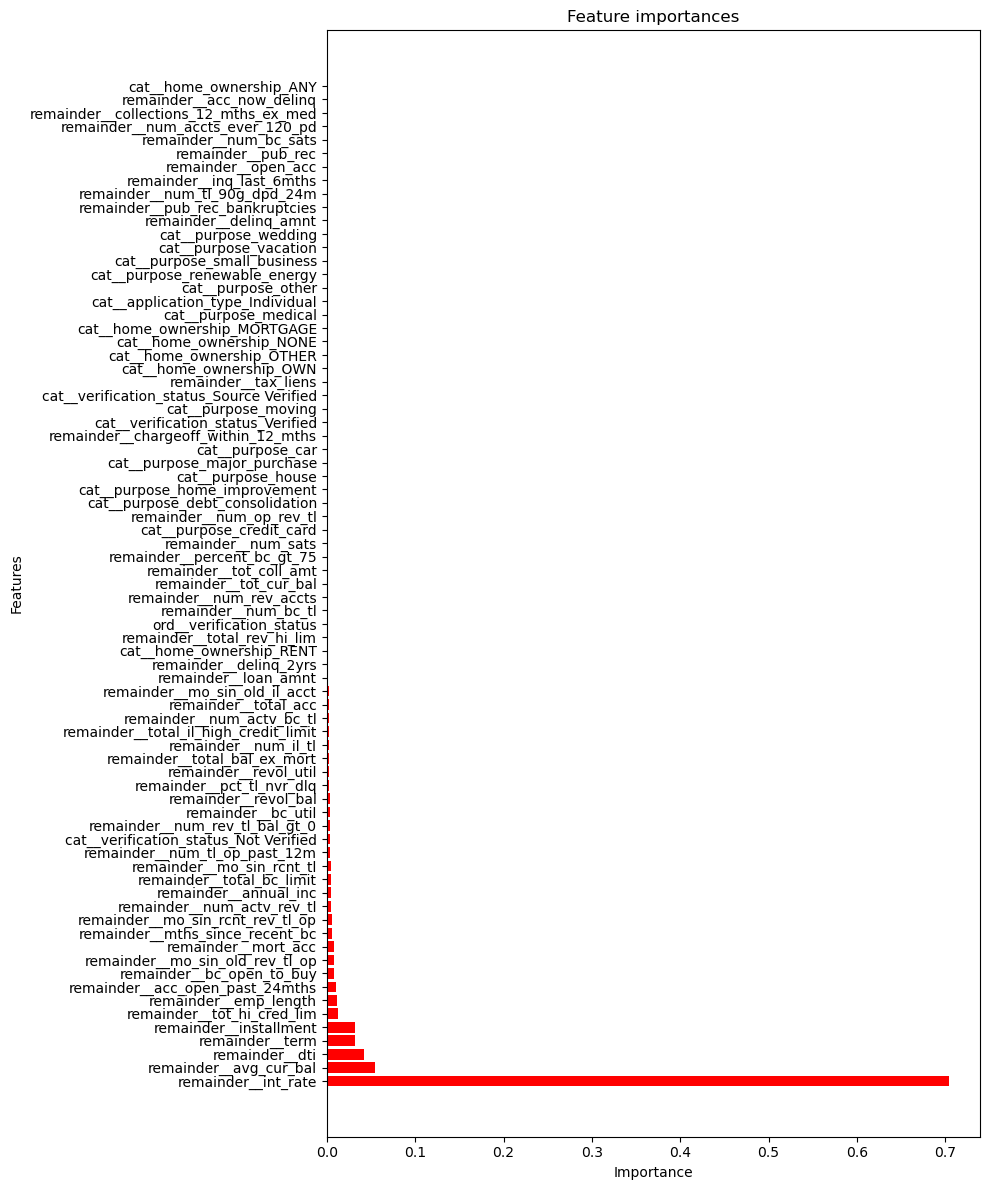

In [12]:
# Get feature names
feature_names_transformed = preprocessor.get_feature_names_out()
print(type(feature_names_transformed))

# Get importances 
importances = best_dt_model.feature_importances_

# Sort and get indices
indices = np.argsort(importances)[::-1]

# PLot
plt.figure(figsize=(10, 12))
plt.title("Feature importances")
plt.barh(range(X_train_transformed.shape[1]), importances[indices], color="r")
plt.yticks(range(X_train_transformed.shape[1]), feature_names_transformed[indices])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Interest rate has the highest importance by far. This was initially worrisome, however, interest rate is not a leaky feature. Instead, it is possible that the larger financial burden brought on by a larger interest rate is enough to force a loan default. However, this is purely speculation and investigated below.

***Tree Diagram***

Due to the depth, the tree will be truncated at a layer of 4 for visualization.  
https://mljar.com/blog/visualize-decision-tree/

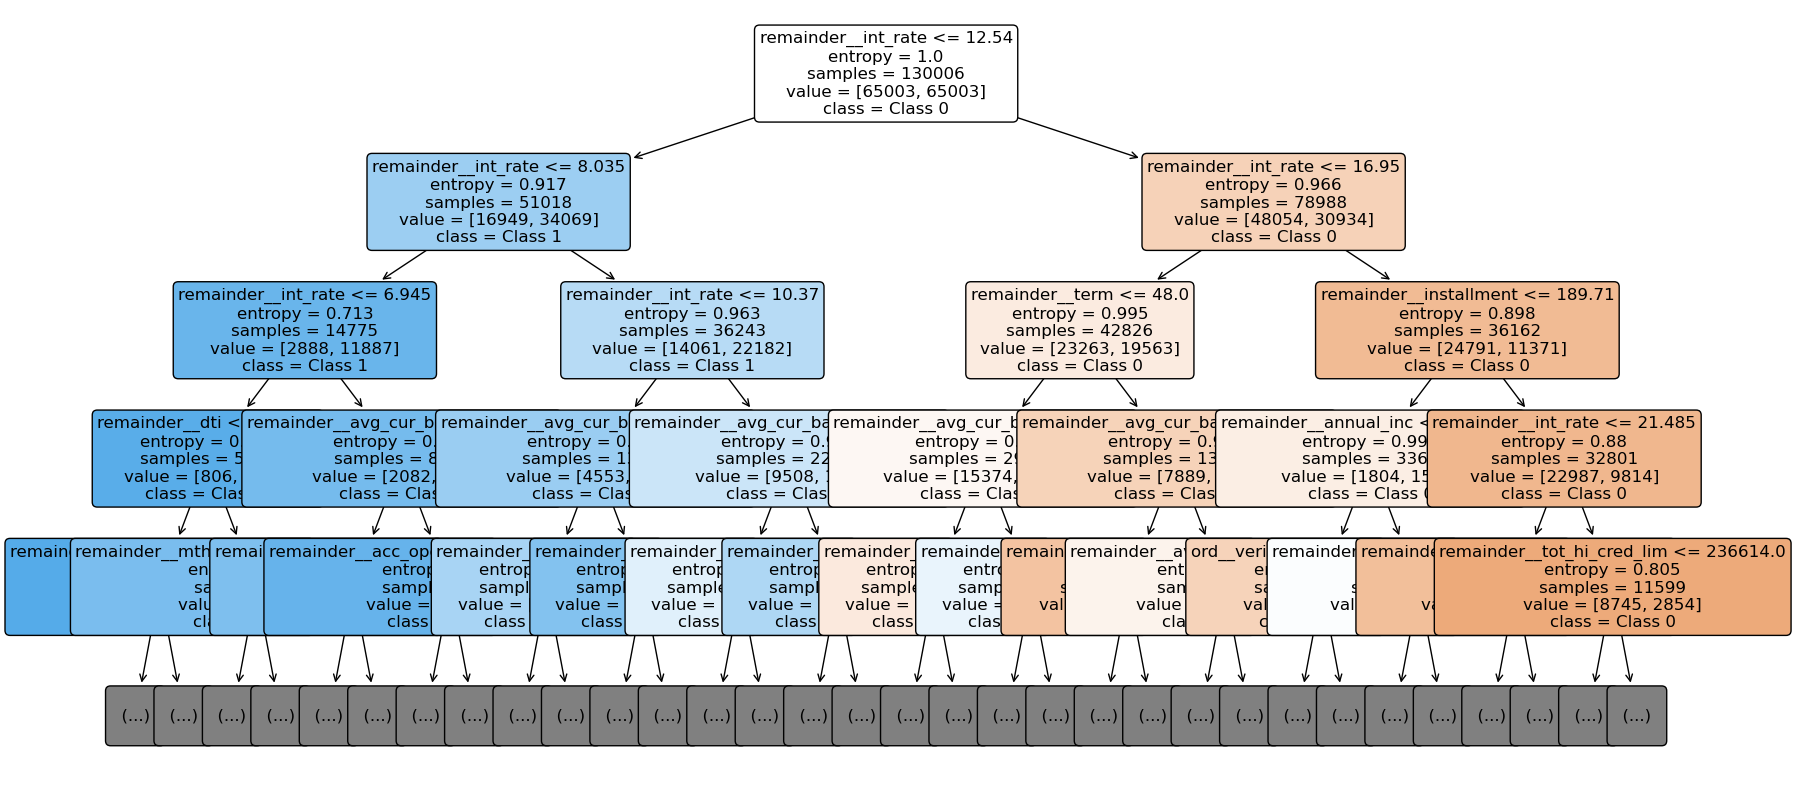

In [13]:
# Convert to a list
feature_names_list = feature_names_transformed.tolist()

plt.figure(figsize=(20,10))
plot_tree(best_dt_model, 
          feature_names=feature_names_list, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True, 
          fontsize=12,
          max_depth=4)
plt.show()

The root is split based off of interest rate, the highest importance feature. This split makes sense, as seen in EDA, the median interest rate for failed loans was 15% whereas for successful loans it as 12%, making it a good discriminator. For failed loans, the next features were the loan term and annual income. 

### 2nd Iteration

Now that there is a baseline decision tree model, we can now vary max depth manually to address the overfitting. Max depth is the most important parameter for controlling overfitting, as it places a limit on how many times the tree can split, thus increasing its purity. Limiting max depth stops the tree from over capturing the noise on the train set, allowing it to better generalize to other data. The previous best model will be used, and the C value iterated. 

***Run the model 2nd Iteration***

In [14]:
%%time
# Define lists for accuracies to be plotted
train_accuracies = []
test_accuracies = []
f1_scores_train = []
f1_scores_test = []

# Depth of 10 to 2 backwards 
for depth in range(10, 1, -1):
    
    # Set max_depth
    best_dt_model.set_params(max_depth=depth)
    
    # Fit 
    best_dt_model.fit(X_train_transformed, y_train_bal)
    
    # Predictions
    y_pred_train = best_dt_model.predict(X_train_transformed)
    y_pred_test = best_dt_model.predict(X_test_transformed)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_bal, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Calculate F1 scores
    f1_train = f1_score(y_train_bal, y_pred_train, average='binary', pos_label=1)
    f1_test = f1_score(y_test, y_pred_test, average='binary', pos_label=1)
    
    # Append to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores_train.append(f1_train)
    f1_scores_test.append(f1_test)
    
    # Print the results for this iteration
    print(f"Max depth: {depth}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train F1 Score: {f1_train:.4f}")
    print(f"Test F1 Score: {f1_test:.4f}")
    print("-" * 30)

Max depth: 10
Train Accuracy: 0.6689
Test Accuracy: 0.6107
Train F1 Score: 0.6546
Test F1 Score: 0.7072
------------------------------
Max depth: 9
Train Accuracy: 0.6600
Test Accuracy: 0.6363
Train F1 Score: 0.6580
Test F1 Score: 0.7341
------------------------------
Max depth: 8
Train Accuracy: 0.6545
Test Accuracy: 0.6209
Train F1 Score: 0.6435
Test F1 Score: 0.7176
------------------------------
Max depth: 7
Train Accuracy: 0.6483
Test Accuracy: 0.6250
Train F1 Score: 0.6400
Test F1 Score: 0.7222
------------------------------
Max depth: 6
Train Accuracy: 0.6455
Test Accuracy: 0.6183
Train F1 Score: 0.6318
Test F1 Score: 0.7143
------------------------------
Max depth: 5
Train Accuracy: 0.6388
Test Accuracy: 0.6175
Train F1 Score: 0.6277
Test F1 Score: 0.7143
------------------------------
Max depth: 4
Train Accuracy: 0.6373
Test Accuracy: 0.6374
Train F1 Score: 0.6385
Test F1 Score: 0.7361
------------------------------
Max depth: 3
Train Accuracy: 0.6317
Test Accuracy: 0.5670
Tra

***2nd model interpretation***

Since the 2nd iteration only focus's on addressing the overfitting, only the train and test scores really need to be evaluated. 

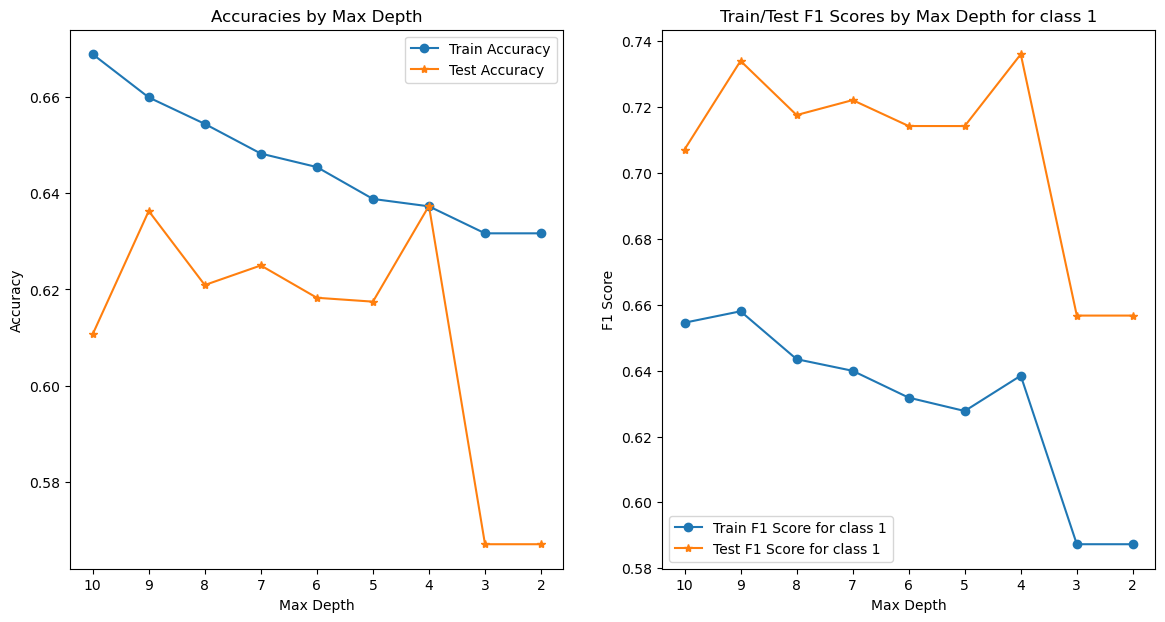

In [15]:
depths = list(range(10, 1, -1))

plt.figure(figsize=(14, 7))

# Plot train and test accuracies
plt.subplot(1, 2, 1)
plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(depths, test_accuracies, marker='*', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracies by Max Depth')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(depths, f1_scores_train, marker='o', label='Train F1 Score for class 1')
plt.plot(depths, f1_scores_test, marker='*', label='Test F1 Score for class 1')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Train/Test F1 Scores by Max Depth for class 1')
plt.legend()
plt.gca().invert_xaxis()

plt.show()

A depth of 4 seems optimal. The train and test accuracies converge, and the f1 score was the highest for the test set. Below a depth of 4 the tree is too shallow to perform well, and above 4 the model overfits and fails to generalize well to the test set. The model also achieves the highest f1 score as well at a depth of 4. 

### 3rd (Final) Iteration

Having established a good range for a few hyperparameters, we can now run an exhaustive search for the best combination. Recall the best parameters found were:  


- 'criterion':entropy    
- 'min_samples_split': 65
- 'min_samples_leaf': 10
- 'max_features': None
- 'max_depth':84  
Max depth will be fixed at 4, as this was found to be optimal, however it is not the only hyperparameter that has a large impact on the models fit. Other hyperparameters also control the models fit, so fixing max depth to 4 does not automatically equate to a possible poor fitting model or guarantee no model overfitting. 

The previous models were fit on class 1 f1 scores, in order to give a range that would lead to a better fitting model overall, and not too narrow if only optimized for precision. However, unlike log reg, there is no threshold that can be modified after the fact to favor precision or recall, so the final model will now be optimized for class 1 precision.


More information on features to control overfitting and important hyperparameters:  
https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter  
https://medium.com/@ompramod9921/decision-trees-8e2391f93fa7

***Run the model 3rd (Final) Iteration***

In [16]:
%%time
# Instantiate
dt_classifier = DecisionTreeClassifier(random_state=1)

# Hyperparameters
param_grid = {
    
    # Keep fixed
    "criterion": ["entropy"],
    "max_depth": [4],

    # Increase to reduce overfitting
    "min_samples_split": [7,8],
    "min_samples_leaf": [11,12],
}
#Best parameters from last iteration: {'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 8, 'criterion': 'entropy'}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1, average='weighted'),
    'recall': make_scorer(recall_score, pos_label=1, average='weighted'),
    'f1': make_scorer(f1_score, pos_label=1, average='binary')
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    dt_classifier, 
    param_grid=param_grid, 
    scoring=scoring, 
    refit='precision', # Refit on precision score for class 1 now
    cv=5, 
    verbose=10,
    n_jobs=3)

# Perform the grid search
grid_search.fit(X_train_transformed, y_train_bal)

# Best model
best_dt_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 7}
CPU times: total: 2.83 s
Wall time: 22.7 s


***Score the model 3rd (Final) Iteration***

Train Accuracy: 0.6373013553220621
Test Accuracy: 0.6373981067087066
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.63      0.42     27859
           1       0.87      0.64      0.74    105982

    accuracy                           0.64    133841
   macro avg       0.59      0.64      0.58    133841
weighted avg       0.75      0.64      0.67    133841



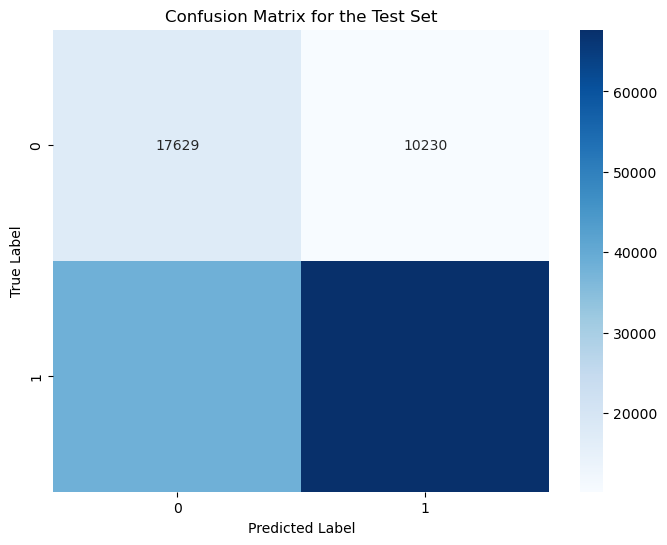

[[17629 10230]
 [38301 67681]]
AUC score:  0.6876923974654774


In [17]:
# Make predictions using the training set and the test set
y_train_pred = best_dt_model.predict(X_train_transformed)
y_test_pred = best_dt_model.predict(X_test_transformed)

# Calculate accuracies for train and test sets
train_accuracy = accuracy_score(y_train_bal, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train and test accuracies
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for the Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# AUC score and ROC curve for the test set
y_test_proba = best_dt_model.predict_proba(X_test_transformed)[:, 1]
auc_score = roc_auc_score(y_test, y_test_proba)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
print(conf_matrix_test)
print('AUC score: ', auc_score)

For the final iteration, we saw a large improvement. The train and test scores are very similar, showing there is no longer any overfitting. Both min_samples_split and min_samples_leaf were increased to help with the issue. However, no improvement was made over the baseline log reg model. For class 1, the same precision of 0.87 was achieved, with a 0.02 decrease in recall. Similarly, for class 0, the precision and recall were slightly worse compared to the baseline. Overall, the weighted average f1 score and AUC dropped by 0.02.    

***3rd model Feature Importance***

<class 'numpy.ndarray'>


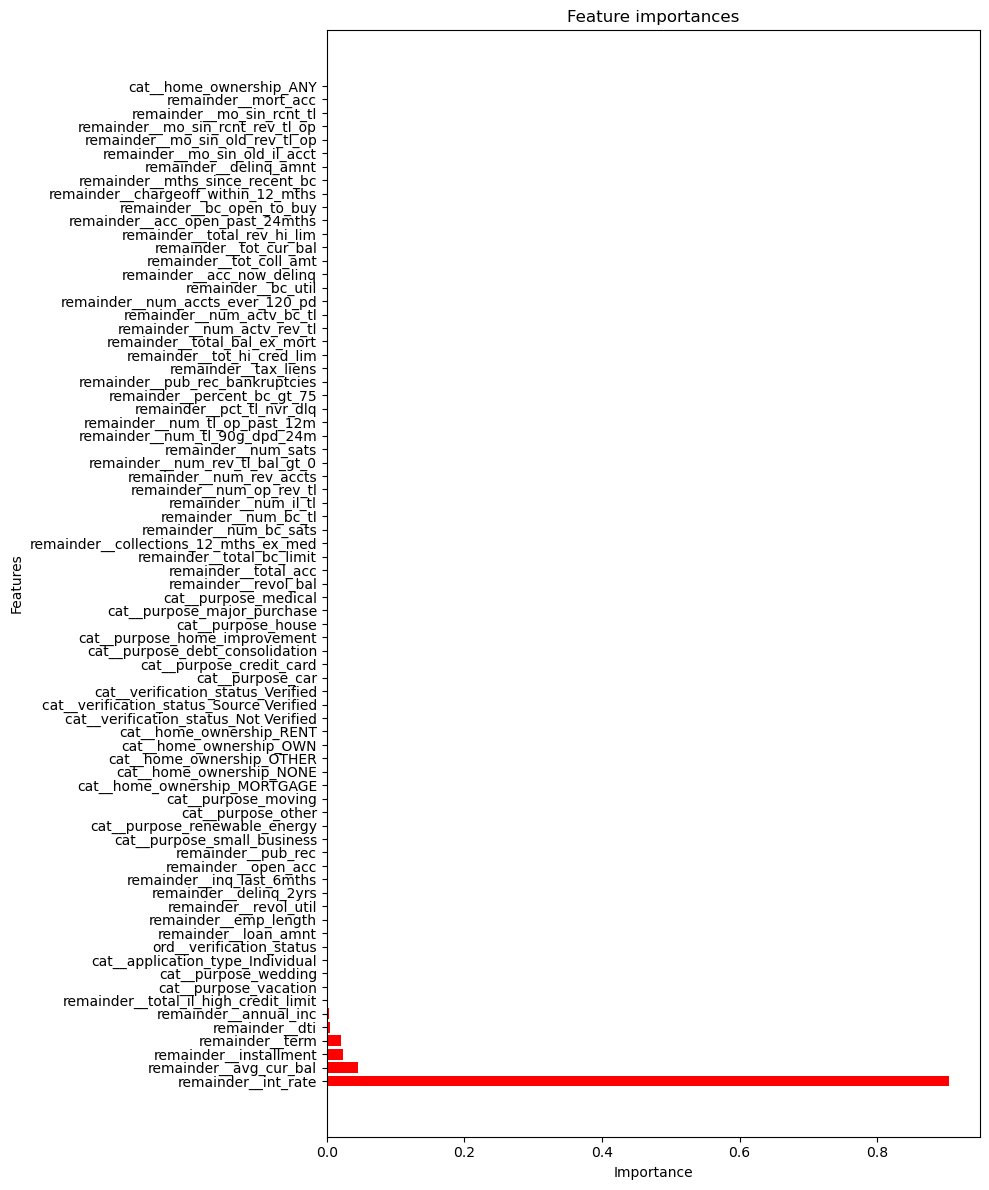

In [18]:
# Get feature names
feature_names_transformed = preprocessor.get_feature_names_out()
print(type(feature_names_transformed))

# Get importances 
importances = best_dt_model.feature_importances_

# Sort and get indices
indices = np.argsort(importances)[::-1]

# PLot
plt.figure(figsize=(10, 12))
plt.title("Feature importances")
plt.barh(range(X_train_transformed.shape[1]), importances[indices], color="r")
plt.yticks(range(X_train_transformed.shape[1]), feature_names_transformed[indices])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Once again, the model is very concentrated on what features is relies on. Interest rate is of the highest. 

***3rd model Tree Diagram***

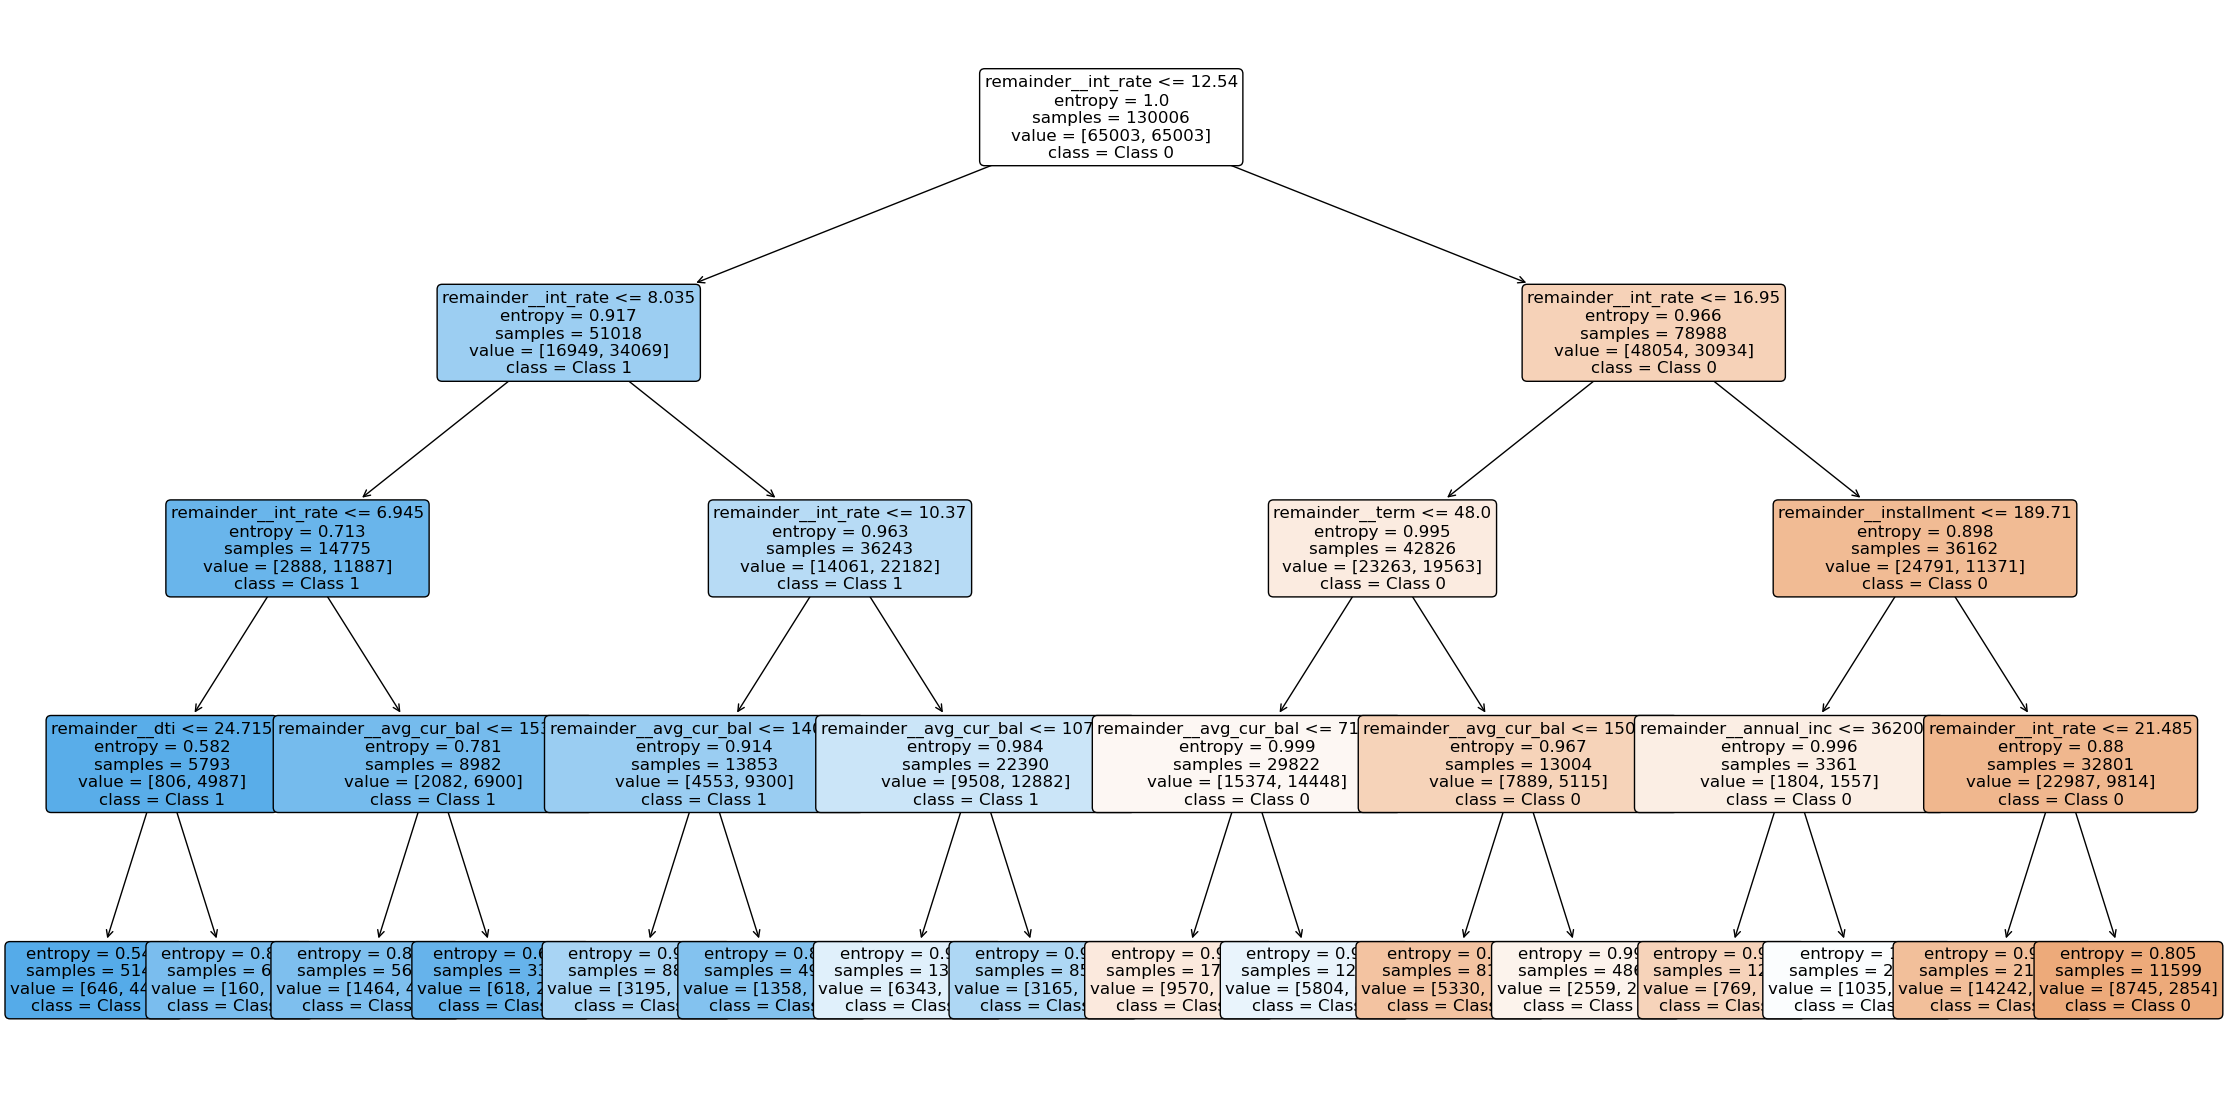

In [19]:
# Convert to a list
feature_names_list = feature_names_transformed.tolist()

plt.figure(figsize=(28,14))
plot_tree(best_dt_model, 
          feature_names=feature_names_list, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True, 
          fontsize=12,
          max_depth=4)
plt.show()

***3rd model SHAP values***

SHAP values are based on game theory and assign an importance value to each feature in a model. Features with positive SHAP values positively impact the prediction, while those with negative values have a negative impact. The magnitude is a measure of how strong the effect is.  

It has a similar function to the feature importance plot above, however, it gives more infomation as well. 
  
https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

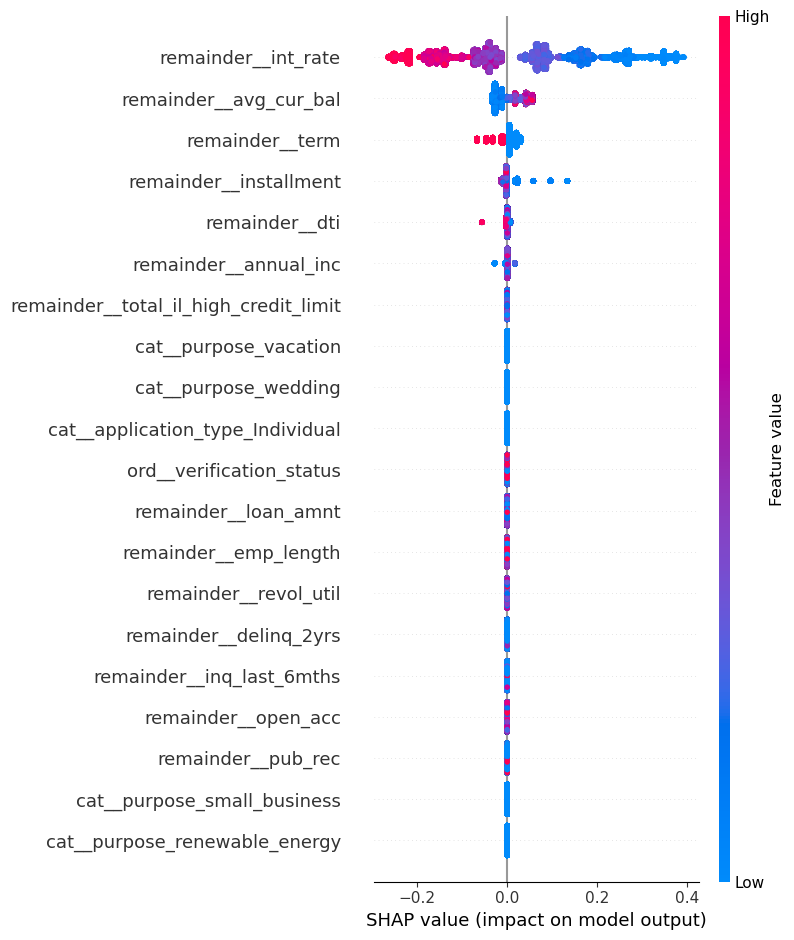

CPU times: total: 23.4 s
Wall time: 23.4 s


In [20]:
%%time
# https://www.kaggle.com/code/dansbecker/shap-values
# Instantiate
explainer = shap.TreeExplainer(best_dt_model)

# Calculate SHAP values
shap_values = explainer(X_test_transformed)

# Selects the SHAP values for the positive class
shap_values_positive_class = shap_values[..., 1] 

# Plot
shap.summary_plot(shap_values_positive_class, X_test_transformed, feature_names=feature_names_transformed)

The summary plot shows the contribution of each feature to the model, for each sample. Each dot refers to a specific loan in the dataset. The color represents the value of the feature, ie, blue indicating lower feature values, red higher. Where on the x axis the dot lies indicates if it was a positive or negative impact, and the magnitude. SHAP values range from -1 to +1.  If there are many dots overlapping, they are seperated sligtly vertically. These plots give far more information compared to the feature importances calculated a few cells above.

For the `int_rate` feature, higher interest rates (in red) tend to have more negative shap values, indicating it pushes the prediction towards the negative class (failed loans). The vice versa is also true; a lower interest rate pushes prediction towards the positive class. Although the color gradient left to right is consistent, there are groupings of interest rates at different shap values.

***Save the 3rd (Final) Iteration***

In [21]:
#relative path to models folder
model_file_path = Path('../Models/best_decision_tree_model.joblib')
dump(best_dt_model, model_file_path)

['..\\Models\\best_decision_tree_model.joblib']

## Random Forest

We can now use a ensemble of decision trees called random forest. It uses the bootstrapping technique. A random sample of the dataset is taken, with replacement, and then a tree is trained on each sample. The theory is that, since the trees are trained on different datasets and that decision trees in general are quite sensitive to small changes in the data, diversity is introduced into the model which helps with the overfitting we experienced above. Max features will also be introduced 

This forest of trees are then aggregated back together for predictions. The consensus protocol is usually a simple majority vote among the trees for classification problems. 

In addition to the hyperparameters for a single decision tree, random forest has:
- n_estimators: The number of trees in the forest. Generally, a larger number of trees increases performance but at a computational cost.

***Fit the model***

In [22]:
%%time
# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=1)

# Hyperparameters grid to search
forrest_param_grid = {
    # Keep fixed
    "criterion": ["entropy"],
    "max_depth": [4,5],

    # Increase to reduce overfitting
    "min_samples_split": [7, 8],
    "min_samples_leaf": [12, 13],

    # Parameters for Random Forest
    "n_estimators": [150],  # Number of trees in the forest. 100 is default
    "max_features": ['sqrt', 'log2'],  # Number of features to consider at every split
    #max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”

}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1, average='binary'),
    'recall': make_scorer(recall_score, pos_label=1, average='binary'),
    'f1': make_scorer(f1_score, pos_label=1, average='binary')
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    rf_classifier, 
    param_grid=forrest_param_grid, 
    scoring=scoring, 
    refit='precision',  # Refit on precision score for class 1
    cv=5, 
    verbose=10,
    n_jobs=3  # Using -1 to use all processors
)

# Perform the grid search
grid_search.fit(X_train_transformed, y_train_bal)

# Best model
best_rf_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(best_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 7, 'n_estimators': 150}
CPU times: total: 33.8 s
Wall time: 17min 51s


***Score the model***

Train Accuracy: 0.6518468378382536
Test Accuracy: 0.6270425355459089
The model might be overfitting.
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.68      0.43     27859
           1       0.88      0.61      0.72    105982

    accuracy                           0.63    133841
   macro avg       0.60      0.65      0.58    133841
weighted avg       0.76      0.63      0.66    133841



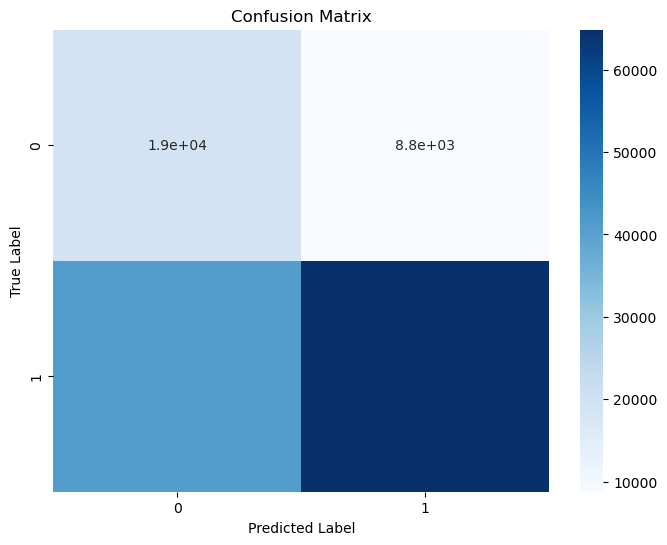

[[19082  8777]
 [41140 64842]]


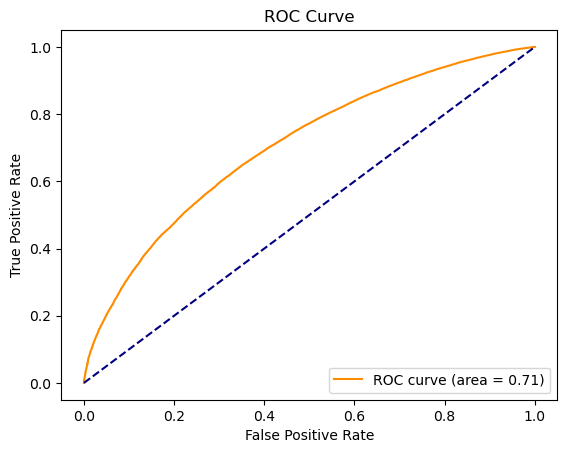

In [23]:
y_train_pred = best_rf_model.predict(X_train_transformed)
y_test_pred = best_rf_model.predict(X_test_transformed)

# Calculate accuracies for train and test sets
train_accuracy = accuracy_score(y_train_bal, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

if train_accuracy > test_accuracy:
    print("The model might be overfitting.")
else:
    print("The model seems to generalize well.")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(conf_matrix)

# Calculate scores
y_test_proba = best_rf_model.predict_proba(X_test_transformed)[:, 1]
auc_score = roc_auc_score(y_test, y_test_proba)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# Plot confusion matrix
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The model's class 1 precision increased from 0.87 to 0.88, however, there is some slight overfitting. On the otherhand, recall dropped by 0.02, with the AUC staying constant. This is the best fitting model, in terms of precision, so far. 

***Save the Random Forest model***

In [24]:
#relative path to models folder
model_file_path = Path('../Models/best_random_forest_model.joblib')
dump(best_rf_model, model_file_path)

['..\\Models\\best_random_forest_model.joblib']

***RF model SHAP values***

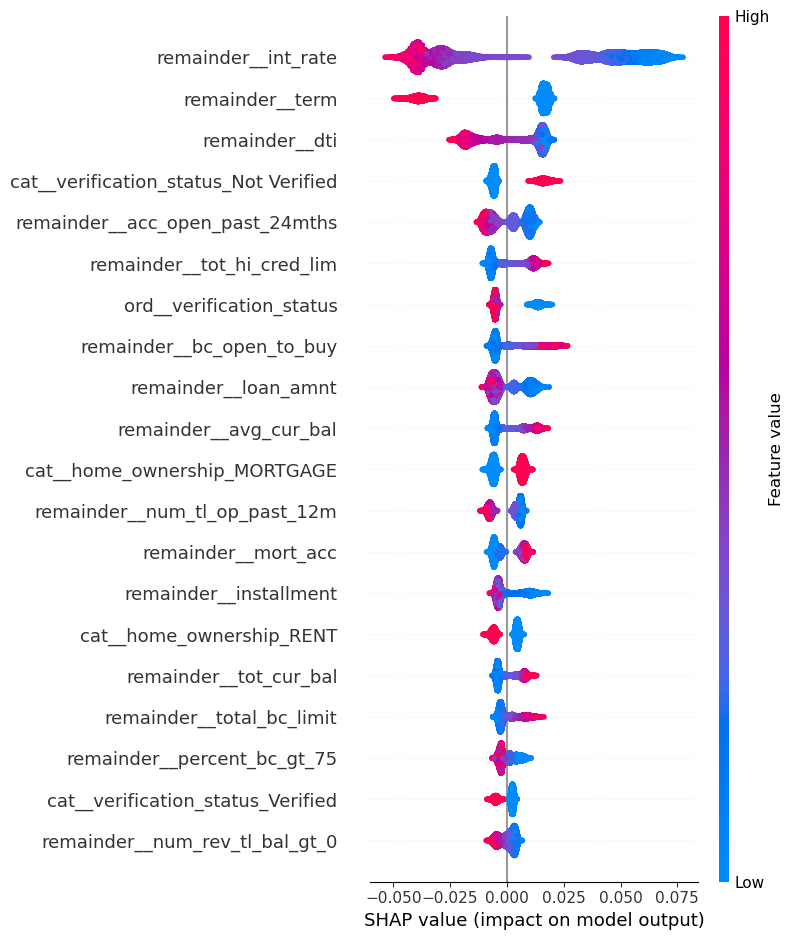

CPU times: total: 2min 42s
Wall time: 2min 42s


In [25]:
%%time
feature_names_transformed = preprocessor.get_feature_names_out()

# Instantiate
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer(X_test_transformed)

shap_values_positive_class = shap_values[..., 1]

# For a global understanding, use the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, X_test_transformed, feature_names=feature_names_transformed)

Interest rate is once again a good predictor. Shorter loan terms have a positive impact on the prediction, similar to the debt to income ratio. A low value in the label-encoded `cat__verification_status_not verified` means the loan has some verification and the feature has a positive impact on the prediction. These examples show how powerful the shap plots are, as they show different points in the features distribution effects the model prediction This is incredibly important to both the investor and borrower as the investor can better justify the decision for extending or withholding credit, increasing both accountability and transparancy. Futhermore, it allows the investor to see how exactly the features are influencing the model, and therefore is make the decision on keeping, removing, or engineering the feature to better.  

The shap plot for the random forest shows a wider distribution of important features compared to that of a single tree. For the single best optimized tree, interest rate was the only really important feature. However, for random forest there are many. This variety results in a model that is less dependent on a single features value, resulting in a more stable model. 

### Conclusion

In this notebook, we explored fitting decision trees and a random forest to our data. For decision trees, a random gridsearch was conducted to get ballpark ranges for hyperparameter values. However, since the model was overfitting, the max depth was manually varied and explored. A depth of 4 was shown to be optimal, achieving high metrics without excessive overfitting. An exhaustive gridsearch was then done based on the previous 2 iterations. This final model showed a large improvement over the previous iteration, however, no improvement over the baseline log reg was made. Finally, a random forest model was fit to the data. This model showed almost exactly the same metrics, however the model is far more stable and less dependent on only a few features. 